In [ ]:
a. Import Required Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


In [ ]:
b. Upload/Access the Dataset and Prepare It

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and flatten
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), -1))  # Flatten 28*28 -> 784
x_test = x_test.reshape((len(x_test), -1))

# Select normal data: digits 0-8 for training (exclude digit 9)
normal_train_mask = y_train != 9
x_train_normal = x_train[normal_train_mask]

# For testing, keep both normal and anomalies
x_test_normal = x_test[y_test != 9]
x_test_anomalies = x_test[y_test == 9]


In [ ]:
c. Define the Encoder (to latent representation)

In [3]:
input_dim = x_train_normal.shape[1]  # 784
encoding_dim = 32  # Dimension of latent space

# Input layer
input_img = Input(shape=(input_dim,))

# Encoder layers
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)


In [ ]:
d. Define the Decoder (reconstruct original input)

In [4]:
# Decoder layers
decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
output = Dense(input_dim, activation='sigmoid')(decoded)


In [ ]:
Create the Autoencoder Model

In [5]:
autoencoder = Model(input_img, output)
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 784)                 │         101,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
e. Compile the Model (Optimizer, Loss, Metrics)

In [6]:
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
Train the Autoencoder on Normal Data

In [8]:
history = autoencoder.fit(x_train_normal, x_train_normal,
                          epochs=5,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=2)


Epoch 1/5
169/169 - 1s - 4ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 2/5
169/169 - 1s - 4ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 3/5
169/169 - 1s - 4ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 4/5
169/169 - 1s - 4ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 5/5
169/169 - 1s - 5ms/step - loss: 0.0091 - val_loss: 0.0094


In [ ]:
Detect Anomalies

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Reconstruction Error for Normal samples: 0.0090
Mean Reconstruction Error for Anomaly samples: 0.0095


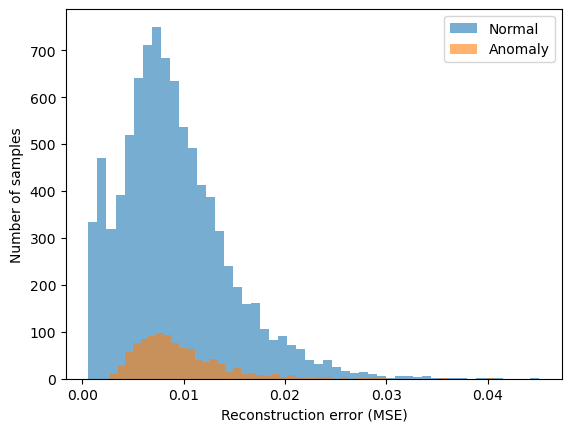

In [9]:
# Calculate reconstruction error for normal and anomaly test samples
reconstructions_normal = autoencoder.predict(x_test_normal)
reconstructions_anomaly = autoencoder.predict(x_test_anomalies)

mse_normal = np.mean(np.power(x_test_normal - reconstructions_normal, 2), axis=1)
mse_anomaly = np.mean(np.power(x_test_anomalies - reconstructions_anomaly, 2), axis=1)

print(f"Mean Reconstruction Error for Normal samples: {np.mean(mse_normal):.4f}")
print(f"Mean Reconstruction Error for Anomaly samples: {np.mean(mse_anomaly):.4f}")

# Plot histogram of errors to visualize separation
plt.hist(mse_normal, bins=50, alpha=0.6, label='Normal')
plt.hist(mse_anomaly, bins=50, alpha=0.6, label='Anomaly')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Number of samples')
plt.legend()
plt.show()
